<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Временные-ряды" data-toc-modified-id="Временные-ряды-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Временные ряды</a></span><ul class="toc-item"><li><span><a href="#1.-Визуальный-анализ-и-предобработка" data-toc-modified-id="1.-Визуальный-анализ-и-предобработка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1. Визуальный анализ и предобработка</a></span></li><li><span><a href="#2.-Стабилизация-дисперсии" data-toc-modified-id="2.-Стабилизация-дисперсии-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>2. Стабилизация дисперсии</a></span></li><li><span><a href="#3.-Дифференцирование" data-toc-modified-id="3.-Дифференцирование-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>3. Дифференцирование</a></span></li><li><span><a href="#4.-Выбор-начальных-значений-для-$p,q$-и-$P,Q$." data-toc-modified-id="4.-Выбор-начальных-значений-для-$p,q$-и-$P,Q$.-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>4. Выбор начальных значений для $p,q$ и $P,Q$.</a></span></li><li><span><a href="#5.-Перебор-и-сравнение-моделей-для-всех-$p,q$-и-$P,Q$,-которые-меньше-или-равны-начальным-значениям" data-toc-modified-id="5.-Перебор-и-сравнение-моделей-для-всех-$p,q$-и-$P,Q$,-которые-меньше-или-равны-начальным-значениям-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>5. Перебор и сравнение моделей для всех $p,q$ и $P,Q$, которые меньше или равны начальным значениям</a></span></li><li><span><a href="#6.-Анализ-остатков" data-toc-modified-id="6.-Анализ-остатков-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>6. Анализ остатков</a></span></li><li><span><a href="#График-модель-+-ряд" data-toc-modified-id="График-модель-+-ряд-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>График модель + ряд</a></span></li><li><span><a href="#Прогноз" data-toc-modified-id="Прогноз-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Прогноз</a></span></li></ul></li></ul></div>

## Временные ряды

Давайте посмотрим, как подгонять модель SARIMA(p,d,q)x(P,D,Q) под временной ряд и анализировать качество полученной модели.

In [1]:
# Как обычно, начнем с импорта стандартных библиотек
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import statsmodels.api as sm # все, для работы с рядами
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса 
from itertools import product # произведения множеств
import warnings # чтобы отключить предупреждения в Python

**Задача.** В файле **wine.csv** содержаться данные о месячных продажах вина в Австралии. Требуется оценить выбрать оптимальную по AIC критерию модель SARIMA и построить прогноз продаж на следующие 3 года.

In [3]:
data = pd.read_csv("data/wine.csv", sep=',') 
data

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019
...,...,...
171,1994-04-01,26323
172,1994-05-01,23779
173,1994-06-01,27549
174,1994-07-01,29660


In [4]:
# импортируем данные
# здесь еще мы дополнительно сделали столбец 'month' индексом,
# преобразовали его содержимое в тип "дата" и указали, что у нас американский формат даты (сначала ) 

data = pd.read_csv("data/wine.csv", sep=',', index_col=['month'], parse_dates=['month'], dayfirst=False) 

### 1. Визуальный анализ и предобработка

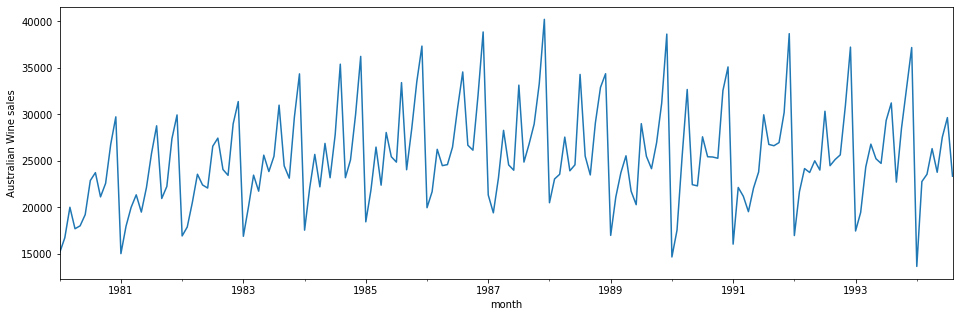

In [5]:
plt.figure(figsize=(16,5))
data.sales.plot()
plt.ylabel('Australian Wine sales')
plt.show()

Мы видим, что временной ряд не содержит пропуски. Начало ряда не сильно отличается от конца ряда, поэтому мы ничего удалять не будем. У ряда видна очевидная годовая сезонность (больше всего вина продается в декабре, меньше всего — в январе). Кроме этого, есть возможный цикл или меняющийся тренд. Наконец, дисперсия ряда увеличивается со временем.  

Удобный инструмент для визуального анализа ряда — его **STL-декомпозиция**. STL расшифровывается как A Seasonal-Trend Decomposition Procedure Based on Loess, и это процедура декомпозиции временного ряда на сезонную, трендовую составляющие и на остатки, использующую метод локальных регрессий (LOESS). И именно с помощью LOESS и происходит сглаживание исходного ряда данных.

<Figure size 1152x576 with 0 Axes>

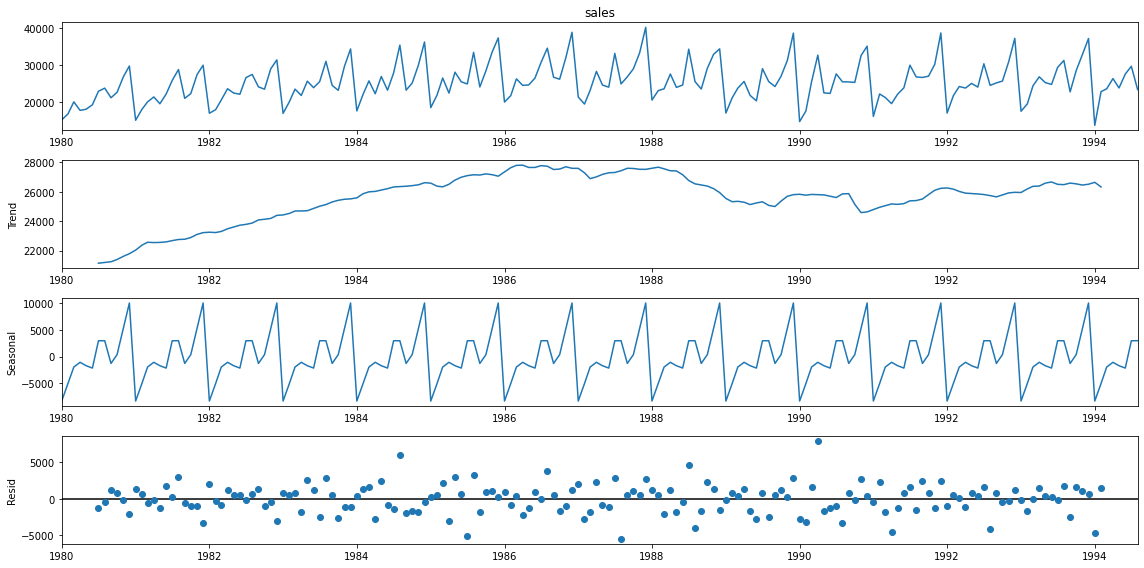

In [6]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.sales).plot()
plt.show()

### 2. Стабилизация дисперсии

Стабилизировать дисперсию мы будем с помощью преобразованися Бокса-Кокса. В Python реализовано это преобразование с автоматичесим подбором параметра $\lambda$. Им мы и воспользуемся. Преобразованный ряд запишем в тот же DataFrame.

In [7]:
data['sales_boxcox'], lmbd = stats.boxcox(data['sales'])

In [8]:
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  0.23667537162383442


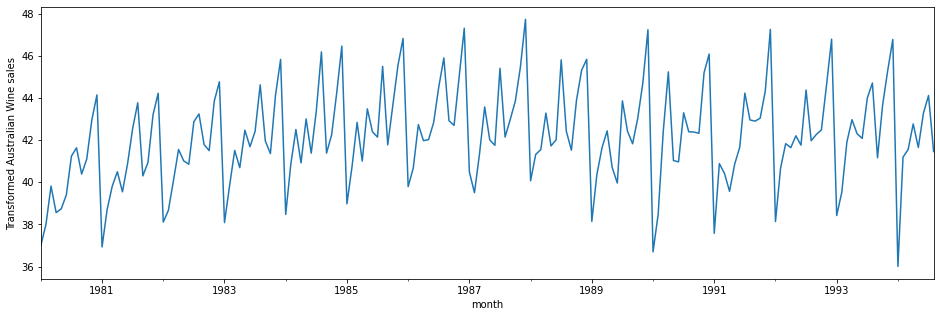

In [9]:
plt.figure(figsize(16,5))
data.sales_boxcox.plot()
plt.ylabel('Transformed Australian Wine sales')
plt.show()

После преобразования Бокса-Кокса дисперсия ряда стала более стабильной. Посмотрим на STL-декомпозицию преобразованного ряда.

<Figure size 1152x576 with 0 Axes>

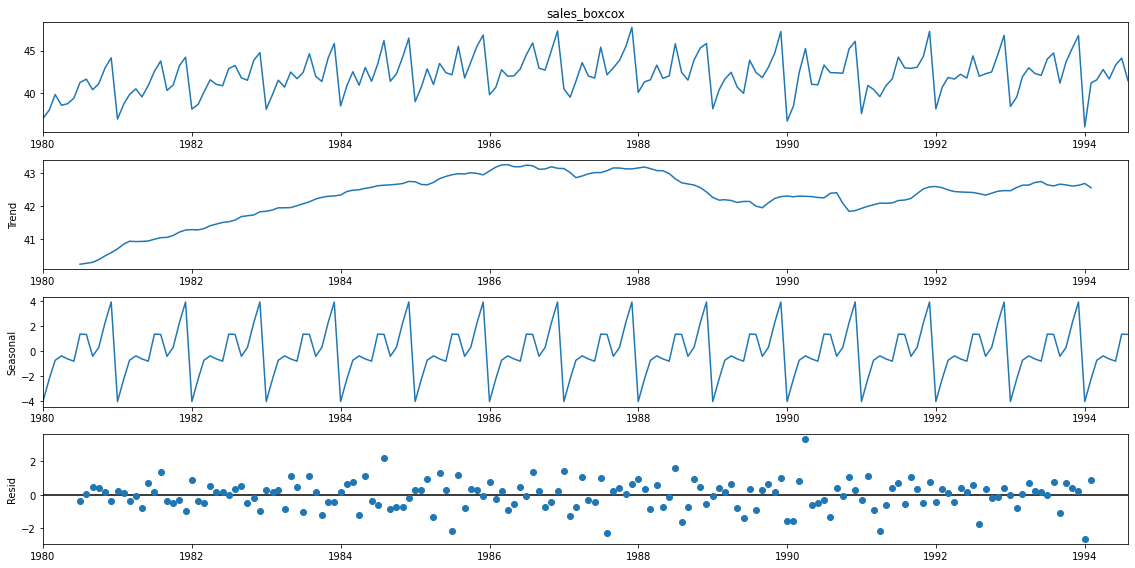

In [10]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.sales_boxcox).plot()
plt.show()

### 3. Дифференцирование

По построенным графикам видно, что данные обладают сезонностью и, возможно, трендом, который необходимо удалить. Этот шаг необходим, чтобы сделать ряд стационарным и подогнать к нему модель SARMA (у нас есть гарантии, что эта модель хорошо описывает только стационарные ряды). Как было сказано на лекции: лучше всего начинать с сезонного дифференцирования.

In [11]:
data['sales_boxcox_diff'] = data.sales_boxcox - data.sales_boxcox.shift(12)

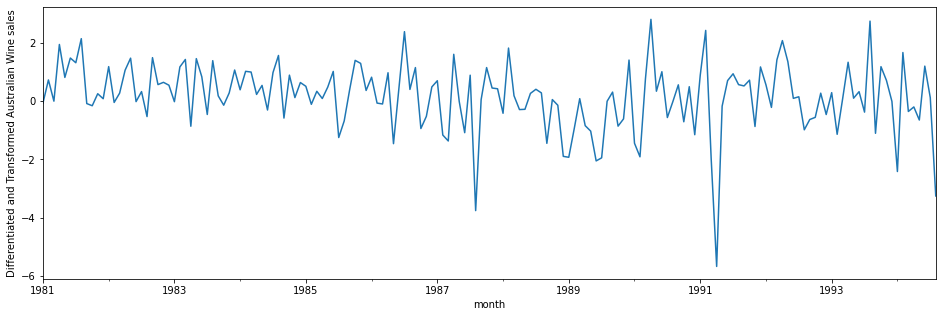

In [12]:
plt.figure(figsize(16,5))
data.sales_boxcox_diff[12:].plot()
plt.ylabel('Differentiated and Transformed Australian Wine sales')
plt.show()

<Figure size 1152x576 with 0 Axes>

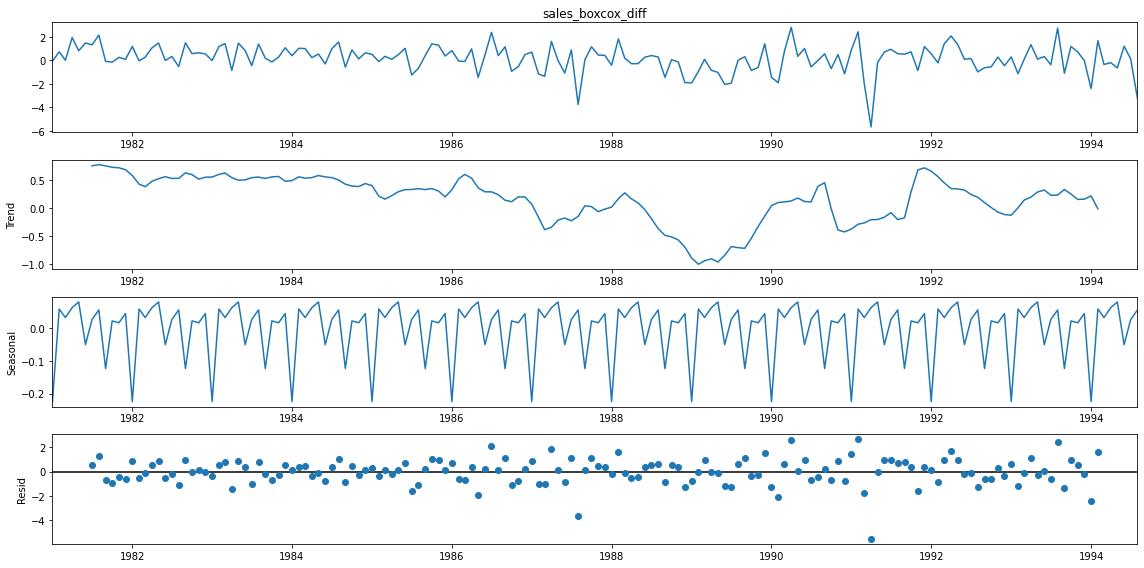

In [13]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.sales_boxcox_diff[12:]).plot()
plt.show()

Видим, что после сезонного дифференцирования пропала только сезонность, но ряд не стал стационарным  (например, потому что у него есть заметный тренд). Сделаем еще одно обычное дифференцирование.

In [14]:
data['sales_boxcox_diff2'] = data.sales_boxcox_diff - data.sales_boxcox_diff.shift(1)

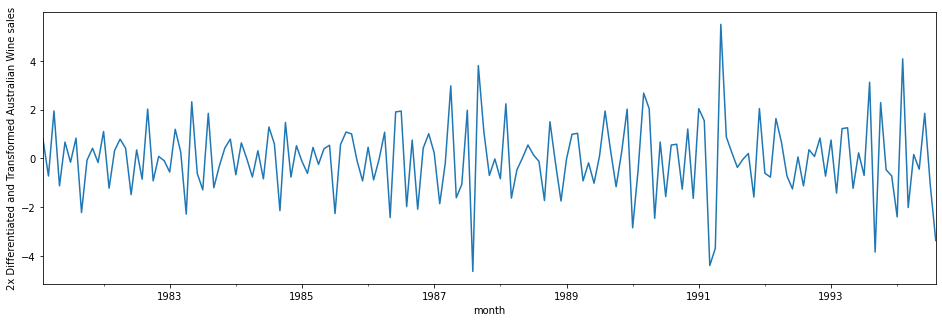

In [15]:
plt.figure(figsize(16,5))
data.sales_boxcox_diff2[13:].plot()
plt.ylabel('2x Differentiated and Transformed Australian Wine sales')
plt.show()

<Figure size 1152x576 with 0 Axes>

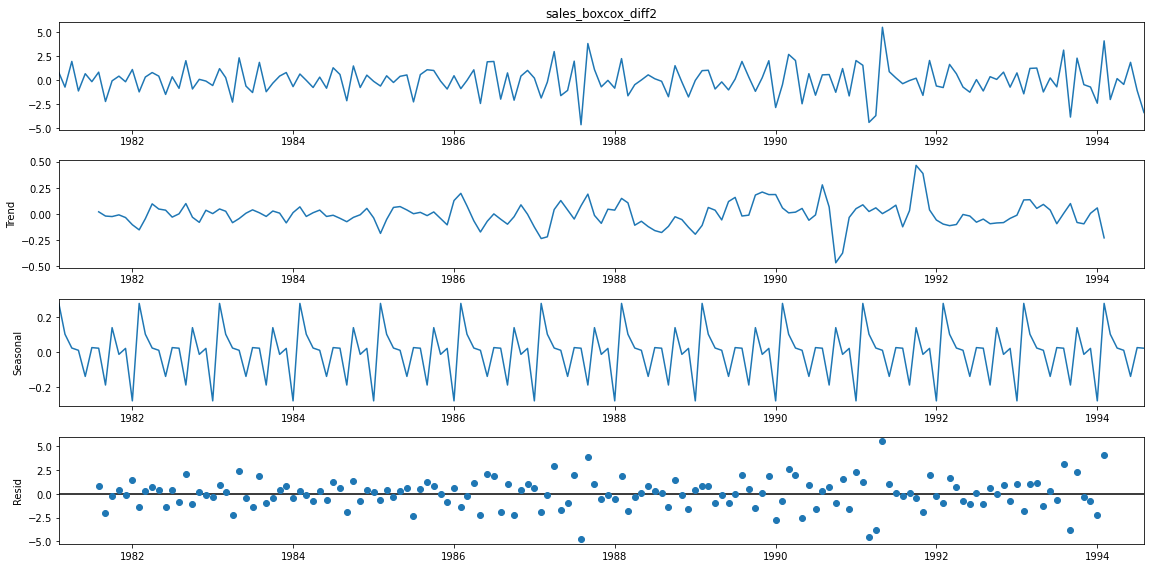

In [16]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.sales_boxcox_diff2[13:]).plot()
plt.show()

Теперь наш ряд стал похож на стационарный. Попробуем формально отвергнуть гипотезу о нестационарности с помощью критерия Дики-Фуллера.

In [17]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",sm.tsa.stattools.adfuller(data.sales_boxcox_diff2[13:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 2.1237369978273356e-06


Гипотеза о нестационарности уверенно отвергается. Для эксперимента проверим с помощью этого критерия еще начальный ряд и ряд после преобразования Бокса-Кокса.

In [18]:
print("Критерий Дики-Фуллера для начального ряда: pvalue =",sm.tsa.stattools.adfuller(data.sales)[1])

Критерий Дики-Фуллера для начального ряда: pvalue = 0.051161152051876754


In [19]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",sm.tsa.stattools.adfuller(data.sales_boxcox_diff[12:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 0.12831728018434946


Видим, что для начального ряда гипотеза о нестационарности отвергается на уровне 6%. Это означает, что данный критерий не являются универсальным и всегда работающим. Поэтому нужно всегда оценивать свои выводы по графикам.

### 4. Выбор начальных значений для $p,q$ и $P,Q$.

Чтобы выбрать начальные значения для $p,q$ и $P,Q$, необходимо построить графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

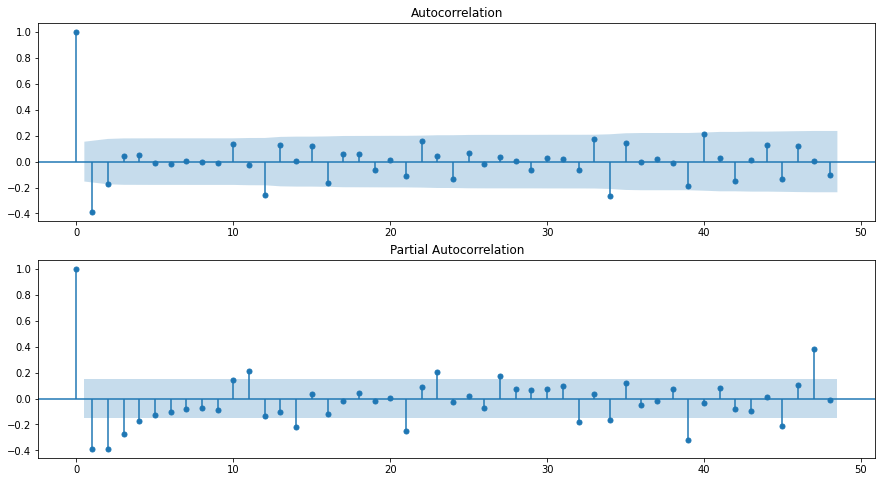

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(data.sales_boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(data.sales_boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax2)

plt.show()

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=1$, $q=2$, $P=2$, $p=4$.

### 5. Перебор и сравнение моделей для всех $p,q$ и $P,Q$, которые меньше или равны начальным значениям

In [21]:
# создадим список из значений параметров для перебора моделей


d=D= 1
ps = range(0, 5)
qs = range(0, 3)
Ps = range(0, 3)
Qs = range(0, 2)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

In [22]:
# посмотрим, сколько моделей нам предстоит обучить

len(parameters_list)

90

In [23]:
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in parameters_list:
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.sales_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

In [24]:
# преобразуем результаты в DataFrame и добавим названия столбцов

result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

In [25]:
# выведем 5 лучших по AIC моделей 

result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
43,"(2, 1, 0, 1)",474.828532
45,"(2, 1, 1, 1)",475.813087
67,"(3, 2, 0, 1)",476.194725
49,"(2, 2, 0, 1)",476.310856
61,"(3, 1, 0, 1)",476.750432


Лучшей моделью получилась SARIMA (2,1,1)x(0,1,1). Именно на ней мы и остановимся. Заметим, что следующие по AIC модели имеют больше параметров, а чем больше параметров у модели — тем более она неустойчива и тем хуже ее вероятностные свойства. Поэтому иногда, если AIC у двух моделей отличается незначительно, то отдать предпочтение нужно той, которая содержит меньше параметров. Так, иногда, стоит выбирать модели, которые находятся на 2-3 месте.

In [26]:
best_model=sm.tsa.statespace.SARIMAX(data.sales_boxcox, order=(2,1,1), seasonal_order=(0,1,1,12)).fit(disp=-1)

In [27]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       sales_boxcox   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -232.414
Date:                            Tue, 14 Sep 2021   AIC                            474.829
Time:                                    13:42:44   BIC                            490.297
Sample:                                01-01-1980   HQIC                           481.109
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111   

### 6. Анализ остатков

Чтобы убедится, что модель хорошая, осталось проанализировать остатки. Сначала посмотрим на них.

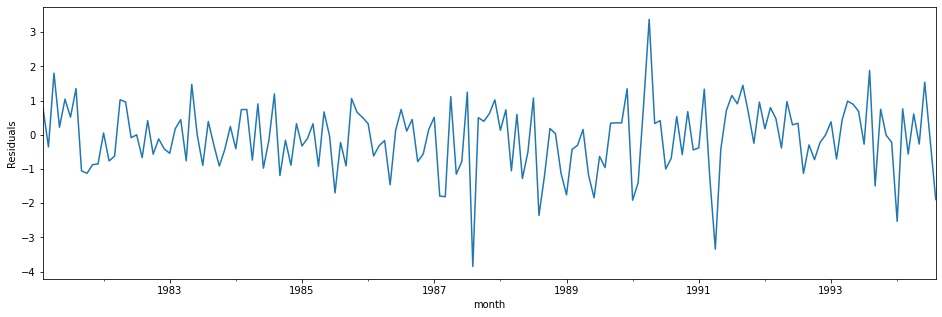

In [28]:
plt.figure(figsize(16,5))
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

Визуально остатки выглядят хорошо. Не видны признаки смещенности, нестационарности или какой-либо зависимости.

**Несмещенность.** Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).

In [29]:
from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",sign_test(best_model.resid[13:])[1])

Критерий знаков для остатков: pvalue = 0.7541603898054363


**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.

In [30]:
print("Критерий Дики-Фуллера для остатков: pvalue =",sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 1.8463667352346197e-23


**Неавтокоррелированность.** Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции.

<Figure size 1152x360 with 0 Axes>

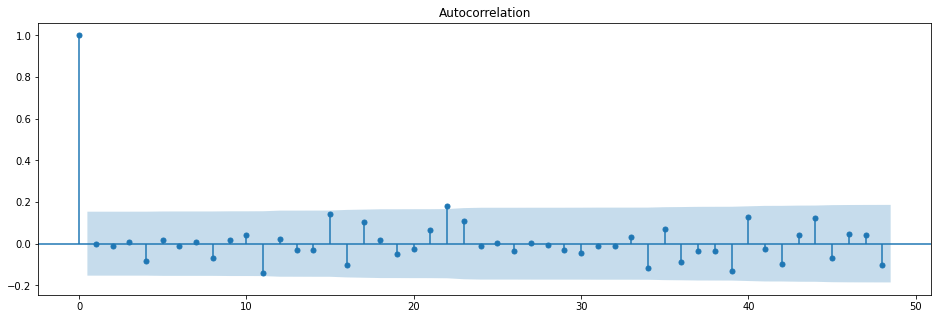

In [31]:
plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48)
plt.show()

Еще обратим внимание, что в summary содержалась информация о Q-критерии Льюнга-Бокса. Этот тест не отвергает нулевую гипотезу о независимости остатков. 

### График модель + ряд

Выведем на графике наш ряд и построенную для него модель. Для этого необходимо сделать обратное преобразование Бокса.

In [32]:
# сохраним значения нашей модели (не забудем сделать обратное преобразование Бокса-Кокса)

data['model'] = inv_boxcox(best_model.fittedvalues, lmbd)

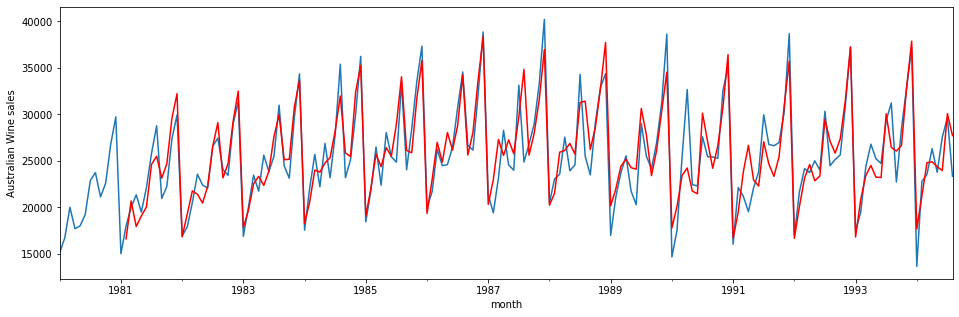

In [33]:
plt.figure(figsize(16,5))
data.sales.plot()
data.model[13:].plot(color='r')
plt.ylabel('Australian Wine sales')
pylab.show()

### Прогноз

Чтобы сделать прогноз, необходимо воспользоваться функцией predict. Так как у DataFrame индексами являются даты, нам необходимо еще записать даты для прогноза. Будем хранить значения ряда и прогноза в new_data.

In [34]:
# сделаем подготовительную работу

plot_data = data[['sales','model']]

date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= plot_data.columns)
plot_data = pd.concat([plot_data, future])

In [35]:
# построим предсказание, сделаем для него обратное преобразование Бокса-Кокса

forecast = inv_boxcox(best_model.predict(start=176, end=211), lmbd)
forecast.index = date_list

In [36]:
# запишем его в столбец Model

plot_data.loc[date_list, 'model'] = forecast

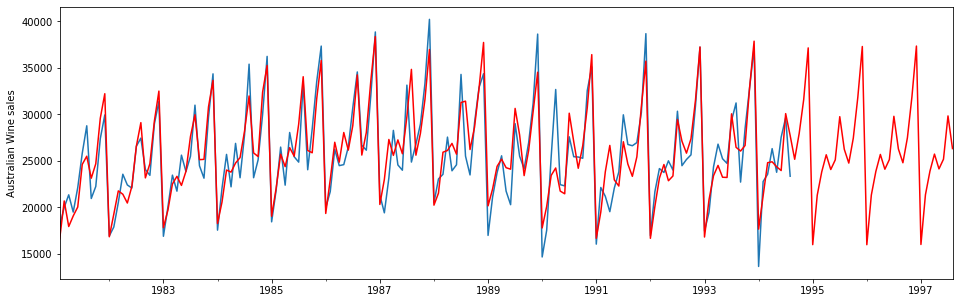

In [37]:
plt.figure(figsize(16,5))
plot_data.sales[13:].plot()
plot_data.model[13:].plot(color='r')
plt.ylabel('Australian Wine sales')
pylab.show()